In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [40]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [41]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Attention Augmented Convolution Module

In [80]:
class AttentionAugmentedConv2d(nn.Module):
    """
    Attention Augmented Convolution as described in:
    "Attention Augmented Convolutional Networks" (Bello et al., 2019)
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, 
                 padding=0, groups=1, bias=False, v=0.2, k=0.2):
        super(AttentionAugmentedConv2d, self).__init__()
        
        # v: ratio of attention output channels to total output channels
        # k: ratio of key/query channels to input channels
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.groups = groups
        self.bias = bias
        self.v = v
        self.k = k
        
        # Calculate channel splits - FIXED to ensure exact total
        self.attn_out_channels = int(out_channels * v)
        self.conv_out_channels = out_channels - self.attn_out_channels  # This ensures exact total
        self.kq_channels = max(1, int(in_channels * k))
        
        # Ensure at least 1 channel for each component
        self.conv_out_channels = max(1, self.conv_out_channels)
        self.attn_out_channels = max(1, self.attn_out_channels)
        
        # If both are forced to at least 1 and that exceeds out_channels, adjust
        if self.conv_out_channels + self.attn_out_channels > out_channels:
            self.attn_out_channels = max(1, out_channels // 2)
            self.conv_out_channels = out_channels - self.attn_out_channels
        
        # Standard convolution branch
        self.conv = nn.Conv2d(in_channels, self.conv_out_channels, kernel_size, 
                             stride=stride, padding=padding, groups=groups, bias=bias)
        
        # Attention branch
        self.query_conv = nn.Conv2d(in_channels, self.kq_channels, 1, bias=False)
        self.key_conv = nn.Conv2d(in_channels, self.kq_channels, 1, bias=False)
        self.value_conv = nn.Conv2d(in_channels, self.attn_out_channels, 1, bias=False)
        
        # Positional encoding for relative attention
        self.rel_h = nn.Parameter(torch.randn(self.kq_channels, 1, 1), requires_grad=True)
        self.rel_w = nn.Parameter(torch.randn(self.kq_channels, 1, 1), requires_grad=True)
        
        # Initialize parameters
        self._init_weights()
        
    def _init_weights(self):
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.query_conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.key_conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.kaiming_normal_(self.value_conv.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self, x):
        batch_size, _, height, width = x.size()
        
        # Standard convolution branch
        conv_out = self.conv(x)
        
        # Get output dimensions from conv
        _, _, h_out, w_out = conv_out.size()
        
        # Attention branch - resize input to match conv output if needed
        if self.stride > 1:
            x_attn = F.avg_pool2d(x, kernel_size=self.stride, stride=self.stride)
        else:
            x_attn = x
            
        # Further resize if dimensions don't match
        if x_attn.size(2) != h_out or x_attn.size(3) != w_out:
            x_attn = F.adaptive_avg_pool2d(x_attn, (h_out, w_out))
        
        # Compute queries, keys, values
        queries = self.query_conv(x_attn)  # [B, kq_channels, H, W]
        keys = self.key_conv(x_attn)       # [B, kq_channels, H, W]
        values = self.value_conv(x_attn)   # [B, attn_out_channels, H, W]
        
        # Reshape for attention computation
        queries = queries.view(batch_size, self.kq_channels, -1)  # [B, kq_channels, HW]
        keys = keys.view(batch_size, self.kq_channels, -1)        # [B, kq_channels, HW]
        values = values.view(batch_size, self.attn_out_channels, -1)  # [B, attn_out_channels, HW]
        
        # Compute attention scores: Q^T @ K
        attention_scores = torch.bmm(queries.transpose(1, 2), keys)  # [B, HW, HW]
        
        # Add relative positional encoding (simplified)
        rel_logits_w = self._relative_logits_1d(queries, self.rel_w, h_out, w_out, transpose=True)
        rel_logits_h = self._relative_logits_1d(queries, self.rel_h, h_out, w_out, transpose=False)
        
        # Add relative logits to attention scores
        attention_scores = attention_scores + rel_logits_h.unsqueeze(2) + rel_logits_w.unsqueeze(1)
        
        # Apply softmax
        attention_weights = F.softmax(attention_scores / (self.kq_channels ** 0.5), dim=-1)
        
        # Apply attention to values: V @ A^T
        attended_values = torch.bmm(values, attention_weights.transpose(1, 2))  # [B, attn_out_channels, HW]
        attended_values = attended_values.view(batch_size, self.attn_out_channels, h_out, w_out)
        
        # Concatenate conv and attention outputs
        output = torch.cat([conv_out, attended_values], dim=1)
        
        # Verify output has correct number of channels
        assert output.size(1) == self.out_channels, f"Output channels mismatch: expected {self.out_channels}, got {output.size(1)}"
        
        return output
    
    def _relative_logits_1d(self, q, rel_k, H, W, transpose=False):
        """Compute relative position logits for 1D case."""
        batch_size = q.size(0)
        
        if transpose:
            # q: [B, kq_channels, HW] -> [B, HW, kq_channels]
            q_t = q.transpose(1, 2)  # [B, HW, kq_channels]
            # Reshape for width-wise relative attention
            q_reshaped = q_t.view(batch_size, H, W, self.kq_channels)
            # Compute relative logits: [B, H, W, kq_channels] x [kq_channels, 1, 1] -> [B, H, W]
            rel_logits = torch.sum(q_reshaped * rel_k.view(1, 1, 1, self.kq_channels), dim=-1)
            rel_logits = rel_logits.view(batch_size, H * W)
        else:
            # q: [B, kq_channels, HW]
            q_reshaped = q.view(batch_size, self.kq_channels, H, W)
            # Compute relative logits: [B, kq_channels, H, W] x [kq_channels, 1, 1] -> [B, H, W]
            rel_logits = torch.sum(q_reshaped * rel_k.view(1, self.kq_channels, 1, 1), dim=1)
            rel_logits = rel_logits.view(batch_size, H * W)
        
        return rel_logits


# ResNet with Attention Augmented Convolutions

In [ ]:
class AttentionAugmentedBottleneck(nn.Module):
    """Bottleneck block with attention augmented convolution"""
    expansion = 4
    
    def __init__(self, inplanes, planes, stride=1, downsample=None, v=0.2, k=0.2):
        super(AttentionAugmentedBottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        
        # Use attention augmented conv for the 3x3 layer
        self.conv2 = AttentionAugmentedConv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, v=v, k=k
        )
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
    
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        if self.downsample is not None:
            residual = self.downsample(x)
        
        out += residual
        out = self.relu(out)
        
        return out



class AttentionAugmentedResNet(nn.Module):
    """ResNet with Attention Augmented Convolutions"""
    
    def __init__(self, block, layers, num_classes=10, v=0.1, k=0.2):
        super(AttentionAugmentedResNet, self).__init__()
    
        self.inplanes = 64
        self.v = v
        self.k = k
        
        # CIFAR-10 optimized initial layers (smaller input size)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Changed for CIFAR
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        # Remove maxpool for CIFAR-10 (too aggressive downsampling)
        
        # ResNet layers with attention
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.1)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                         kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.v, self.k))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, v=self.v, k=self.k))
        
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # No maxpool for CIFAR-10
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # Add dropout before final layer
        x = self.fc(x)
        return x



In [ ]:


def create_aa_resnet18(num_classes=10, v=0.1, k=0.2):
    """Create ResNet18 with Attention Augmented Convolutions - better for CIFAR-10"""
    return AttentionAugmentedResNet(AttentionAugmentedBottleneck, [2, 2, 2, 2], 
                                   num_classes=num_classes, v=v, k=k)


print(f"Model parameters: {count_parameters(model):,}")

Model parameters: 13,693,506


# Data Loading and Preprocessing

In [83]:
# Data transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Number of classes: {len(classes)}")

Training samples: 50000
Test samples: 10000
Number of classes: 10


# Visualization

Sample training images:


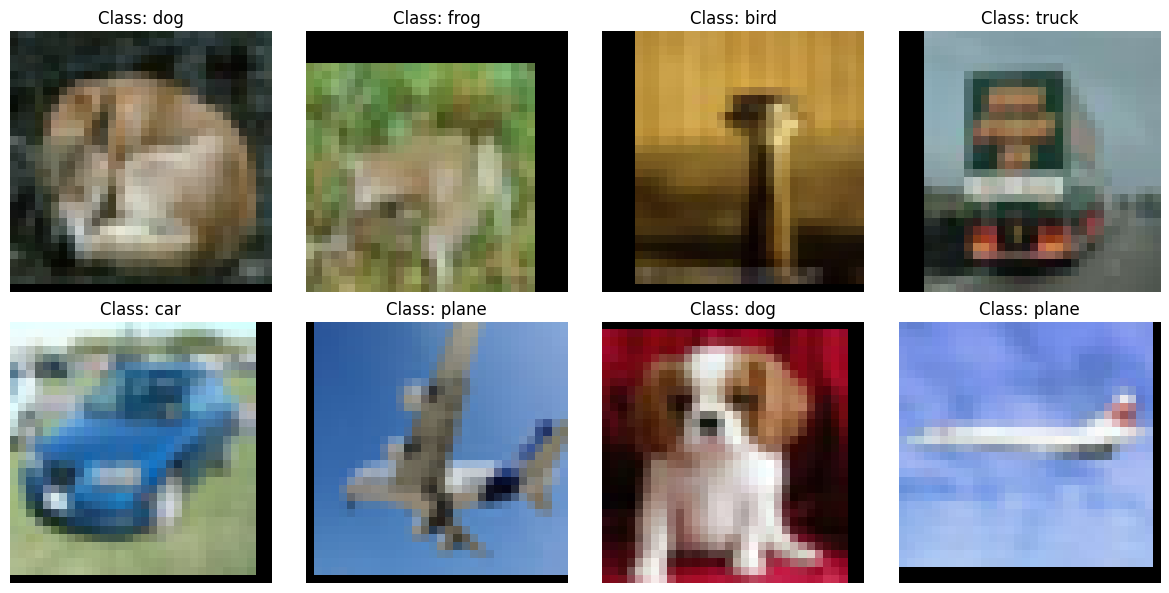

In [84]:
def visualize_samples(dataloader, classes, num_samples=8):
    """Visualize sample images from the dataset"""
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    
    # Denormalize images for visualization
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(num_samples):
        row, col = i // 4, i % 4
        axes[row, col].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[row, col].set_title(f'Class: {classes[labels[i]]}')
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize training samples
print("Sample training images:")
visualize_samples(trainloader, classes)

# Model Initialization

In [123]:
# Create models for comparison
standard_resnet = torchvision.models.resnet18(num_classes=10)
aa_resnet = create_aa_resnet18(num_classes=10, v=0.2, k=0.2)

# Move models to device
standard_resnet = standard_resnet.to(device)
aa_resnet = aa_resnet.to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Comparison:")
print(f"Standard ResNet18 parameters: {count_parameters(standard_resnet):,}")
print(f"AA-ResNet18 parameters: {count_parameters(aa_resnet):,}")
print(f"Parameter increase: {count_parameters(aa_resnet) - count_parameters(standard_resnet):,}")

# Visualize model architecture
def print_model_summary(model, model_name):
    print(f"\n{model_name} Architecture Summary:")
    print("-" * 50)
    total_params = 0
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Leaf modules
            params = sum(p.numel() for p in module.parameters())
            if params > 0:
                print(f"{name}: {params:,} parameters")
                total_params += params
    print(f"Total: {total_params:,} parameters")

print_model_summary(aa_resnet, "Attention Augmented ResNet50")

Model Comparison:
Standard ResNet18 parameters: 11,181,642
AA-ResNet18 parameters: 13,128,770
Parameter increase: 1,947,128

Attention Augmented ResNet50 Architecture Summary:
--------------------------------------------------
conv1: 1,728 parameters
bn1: 128 parameters
layer1.0.conv1: 4,096 parameters
layer1.0.bn1: 128 parameters
layer1.0.conv2.conv: 29,952 parameters
layer1.0.conv2.query_conv: 768 parameters
layer1.0.conv2.key_conv: 768 parameters
layer1.0.conv2.value_conv: 768 parameters
layer1.0.bn2: 128 parameters
layer1.0.conv3: 16,384 parameters
layer1.0.bn3: 512 parameters
layer1.0.downsample.0: 16,384 parameters
layer1.0.downsample.1: 512 parameters
layer1.1.conv1: 16,384 parameters
layer1.1.bn1: 128 parameters
layer1.1.conv2.conv: 29,952 parameters
layer1.1.conv2.query_conv: 768 parameters
layer1.1.conv2.key_conv: 768 parameters
layer1.1.conv2.value_conv: 768 parameters
layer1.1.bn2: 128 parameters
layer1.1.conv3: 16,384 parameters
layer1.1.bn3: 512 parameters
layer2.0.conv1:

# Training Setup

In [105]:
def train_model(model, trainloader, criterion, optimizer, scheduler=None, epochs=10):
    """Train the model with improved training procedures"""
    model.train()
    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping - crucial for attention models
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        if scheduler:
            scheduler.step()
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies


In [116]:
def test_model(model, testloader):
    """Test the model"""
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for inputs, targets in tqdm(testloader, desc='Testing'):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Per-class accuracy
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    test_loss /= len(testloader)
    test_acc = 100. * correct / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
    
    # Print per-class accuracy
    print("\nPer-class accuracy:")
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {acc:.2f}%')
    
    return test_loss, test_acc, class_correct, class_total


# Train Attention Augmented ResNet

In [ ]:

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for regularization

optimizer = optim.SGD(model.parameters(), 
                     lr=0.1, 
                     momentum=0.9, 
                     weight_decay=5e-4,
                     nesterov=True)

# Learning rate scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, 
                                          milestones=[60, 120, 160], 
                                          gamma=0.2)

epochs = 200
print(f"Training for {epochs} epochs...")

# Train the model
train_losses, train_accuracies = train_model(
    model, trainloader, criterion, optimizer, scheduler, epochs=epochs
)

# Test the model
test_accuracy = test_model(model, testloader)

Training for 200 epochs...


Epoch 1/200: 100%|██████████| 391/391 [00:22<00:00, 17.21it/s, Loss=2.169, Acc=30.10%]


Epoch 1: Loss: 2.1692, Accuracy: 30.10%


Epoch 2/200: 100%|██████████| 391/391 [00:21<00:00, 18.08it/s, Loss=1.836, Acc=45.14%]


Epoch 2: Loss: 1.8355, Accuracy: 45.14%


Epoch 3/200: 100%|██████████| 391/391 [00:21<00:00, 18.43it/s, Loss=1.626, Acc=53.08%]


Epoch 3: Loss: 1.6262, Accuracy: 53.08%


Epoch 4/200: 100%|██████████| 391/391 [00:21<00:00, 18.38it/s, Loss=1.468, Acc=58.17%]


Epoch 4: Loss: 1.4679, Accuracy: 58.17%


Epoch 5/200: 100%|██████████| 391/391 [00:21<00:00, 18.20it/s, Loss=1.346, Acc=62.49%]


Epoch 5: Loss: 1.3462, Accuracy: 62.49%


Epoch 6/200: 100%|██████████| 391/391 [00:21<00:00, 18.22it/s, Loss=1.266, Acc=65.76%]


Epoch 6: Loss: 1.2658, Accuracy: 65.76%


Epoch 7/200: 100%|██████████| 391/391 [00:21<00:00, 18.22it/s, Loss=1.207, Acc=68.48%]


Epoch 7: Loss: 1.2074, Accuracy: 68.48%


Epoch 8/200: 100%|██████████| 391/391 [00:21<00:00, 18.24it/s, Loss=1.172, Acc=70.06%]


Epoch 8: Loss: 1.1724, Accuracy: 70.06%


Epoch 9/200: 100%|██████████| 391/391 [00:21<00:00, 18.14it/s, Loss=1.142, Acc=71.42%]


Epoch 9: Loss: 1.1417, Accuracy: 71.42%


Epoch 10/200: 100%|██████████| 391/391 [00:21<00:00, 18.24it/s, Loss=1.123, Acc=72.40%]


Epoch 10: Loss: 1.1232, Accuracy: 72.40%


Epoch 11/200: 100%|██████████| 391/391 [00:21<00:00, 18.37it/s, Loss=1.105, Acc=73.28%]


Epoch 11: Loss: 1.1054, Accuracy: 73.28%


Epoch 12/200: 100%|██████████| 391/391 [00:21<00:00, 18.36it/s, Loss=1.093, Acc=73.86%]


Epoch 12: Loss: 1.0931, Accuracy: 73.86%


Epoch 13/200: 100%|██████████| 391/391 [00:21<00:00, 18.28it/s, Loss=1.085, Acc=73.86%]


Epoch 13: Loss: 1.0852, Accuracy: 73.86%


Epoch 14/200: 100%|██████████| 391/391 [00:21<00:00, 18.28it/s, Loss=1.071, Acc=74.65%]


Epoch 14: Loss: 1.0707, Accuracy: 74.65%


Epoch 15/200: 100%|██████████| 391/391 [00:21<00:00, 18.56it/s, Loss=1.070, Acc=75.05%]


Epoch 15: Loss: 1.0698, Accuracy: 75.05%


Epoch 16/200: 100%|██████████| 391/391 [00:21<00:00, 18.38it/s, Loss=1.056, Acc=75.36%]


Epoch 16: Loss: 1.0559, Accuracy: 75.36%


Epoch 17/200: 100%|██████████| 391/391 [00:21<00:00, 18.21it/s, Loss=1.054, Acc=75.44%]


Epoch 17: Loss: 1.0541, Accuracy: 75.44%


Epoch 18/200: 100%|██████████| 391/391 [00:21<00:00, 18.34it/s, Loss=1.045, Acc=75.90%]


Epoch 18: Loss: 1.0449, Accuracy: 75.90%


Epoch 19/200: 100%|██████████| 391/391 [00:21<00:00, 18.41it/s, Loss=1.040, Acc=76.15%]


Epoch 19: Loss: 1.0404, Accuracy: 76.15%


Epoch 20/200: 100%|██████████| 391/391 [00:21<00:00, 18.17it/s, Loss=1.038, Acc=76.14%]


Epoch 20: Loss: 1.0379, Accuracy: 76.14%


Epoch 21/200: 100%|██████████| 391/391 [00:21<00:00, 18.33it/s, Loss=1.035, Acc=76.37%]


Epoch 21: Loss: 1.0353, Accuracy: 76.37%


Epoch 22/200: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s, Loss=1.028, Acc=76.72%]


Epoch 22: Loss: 1.0283, Accuracy: 76.72%


Epoch 23/200: 100%|██████████| 391/391 [00:21<00:00, 18.42it/s, Loss=1.029, Acc=76.62%]


Epoch 23: Loss: 1.0289, Accuracy: 76.62%


Epoch 24/200: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s, Loss=1.026, Acc=76.77%]


Epoch 24: Loss: 1.0259, Accuracy: 76.77%


Epoch 25/200: 100%|██████████| 391/391 [00:21<00:00, 18.39it/s, Loss=1.018, Acc=77.16%]


Epoch 25: Loss: 1.0176, Accuracy: 77.16%


Epoch 26/200: 100%|██████████| 391/391 [00:21<00:00, 18.34it/s, Loss=1.014, Acc=77.27%]


Epoch 26: Loss: 1.0139, Accuracy: 77.27%


Epoch 27/200: 100%|██████████| 391/391 [00:21<00:00, 18.55it/s, Loss=1.014, Acc=77.29%]


Epoch 27: Loss: 1.0143, Accuracy: 77.29%


Epoch 28/200: 100%|██████████| 391/391 [00:21<00:00, 18.36it/s, Loss=1.011, Acc=77.31%]


Epoch 28: Loss: 1.0109, Accuracy: 77.31%


Epoch 29/200: 100%|██████████| 391/391 [00:21<00:00, 18.36it/s, Loss=1.007, Acc=77.48%]


Epoch 29: Loss: 1.0073, Accuracy: 77.48%


Epoch 30/200: 100%|██████████| 391/391 [00:21<00:00, 18.43it/s, Loss=1.003, Acc=77.88%]


Epoch 30: Loss: 1.0032, Accuracy: 77.88%


Epoch 31/200: 100%|██████████| 391/391 [00:21<00:00, 18.39it/s, Loss=1.002, Acc=77.87%]


Epoch 31: Loss: 1.0015, Accuracy: 77.87%


Epoch 32/200: 100%|██████████| 391/391 [00:21<00:00, 18.29it/s, Loss=0.997, Acc=78.08%]


Epoch 32: Loss: 0.9967, Accuracy: 78.08%


Epoch 33/200: 100%|██████████| 391/391 [00:21<00:00, 18.42it/s, Loss=1.001, Acc=77.72%]


Epoch 33: Loss: 1.0010, Accuracy: 77.72%


Epoch 34/200: 100%|██████████| 391/391 [00:21<00:00, 18.33it/s, Loss=0.997, Acc=78.14%]


Epoch 34: Loss: 0.9973, Accuracy: 78.14%


Epoch 35/200: 100%|██████████| 391/391 [00:21<00:00, 18.46it/s, Loss=0.998, Acc=78.01%]


Epoch 35: Loss: 0.9985, Accuracy: 78.01%


Epoch 36/200: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s, Loss=0.999, Acc=78.02%]


Epoch 36: Loss: 0.9992, Accuracy: 78.02%


Epoch 37/200: 100%|██████████| 391/391 [00:21<00:00, 18.28it/s, Loss=0.995, Acc=78.07%]


Epoch 37: Loss: 0.9953, Accuracy: 78.07%


Epoch 38/200: 100%|██████████| 391/391 [00:21<00:00, 18.47it/s, Loss=0.992, Acc=78.12%]


Epoch 38: Loss: 0.9923, Accuracy: 78.12%


Epoch 39/200: 100%|██████████| 391/391 [00:21<00:00, 18.46it/s, Loss=0.992, Acc=78.07%]


Epoch 39: Loss: 0.9921, Accuracy: 78.07%


Epoch 40/200: 100%|██████████| 391/391 [00:21<00:00, 18.30it/s, Loss=0.993, Acc=78.11%]


Epoch 40: Loss: 0.9928, Accuracy: 78.11%


Epoch 41/200: 100%|██████████| 391/391 [00:21<00:00, 18.45it/s, Loss=0.989, Acc=78.44%]


Epoch 41: Loss: 0.9886, Accuracy: 78.44%


Epoch 42/200: 100%|██████████| 391/391 [00:21<00:00, 18.45it/s, Loss=0.989, Acc=78.32%]


Epoch 42: Loss: 0.9888, Accuracy: 78.32%


Epoch 43/200: 100%|██████████| 391/391 [00:21<00:00, 18.39it/s, Loss=0.989, Acc=78.37%]


Epoch 43: Loss: 0.9886, Accuracy: 78.37%


Epoch 44/200: 100%|██████████| 391/391 [00:21<00:00, 18.39it/s, Loss=0.984, Acc=78.68%]


Epoch 44: Loss: 0.9843, Accuracy: 78.68%


Epoch 45/200: 100%|██████████| 391/391 [00:21<00:00, 18.50it/s, Loss=0.991, Acc=78.42%]


Epoch 45: Loss: 0.9908, Accuracy: 78.42%


Epoch 46/200: 100%|██████████| 391/391 [00:21<00:00, 18.43it/s, Loss=0.987, Acc=78.49%]


Epoch 46: Loss: 0.9873, Accuracy: 78.49%


Epoch 47/200: 100%|██████████| 391/391 [00:21<00:00, 18.46it/s, Loss=0.983, Acc=78.81%]


Epoch 47: Loss: 0.9834, Accuracy: 78.81%


Epoch 48/200: 100%|██████████| 391/391 [00:21<00:00, 18.43it/s, Loss=0.984, Acc=78.75%]


Epoch 48: Loss: 0.9837, Accuracy: 78.75%


Epoch 49/200: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s, Loss=0.985, Acc=78.62%]


Epoch 49: Loss: 0.9850, Accuracy: 78.62%


Epoch 50/200: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s, Loss=0.983, Acc=78.55%]


Epoch 50: Loss: 0.9827, Accuracy: 78.55%


Epoch 51/200: 100%|██████████| 391/391 [00:21<00:00, 17.81it/s, Loss=0.982, Acc=78.62%]


Epoch 51: Loss: 0.9817, Accuracy: 78.62%


Epoch 52/200: 100%|██████████| 391/391 [00:21<00:00, 17.95it/s, Loss=0.981, Acc=78.68%]


Epoch 52: Loss: 0.9814, Accuracy: 78.68%


Epoch 53/200: 100%|██████████| 391/391 [00:22<00:00, 17.76it/s, Loss=0.978, Acc=79.06%]


Epoch 53: Loss: 0.9778, Accuracy: 79.06%


Epoch 54/200: 100%|██████████| 391/391 [00:22<00:00, 17.68it/s, Loss=0.982, Acc=78.79%]


Epoch 54: Loss: 0.9824, Accuracy: 78.79%


Epoch 55/200: 100%|██████████| 391/391 [00:21<00:00, 18.00it/s, Loss=0.978, Acc=78.94%]


Epoch 55: Loss: 0.9779, Accuracy: 78.94%


Epoch 56/200: 100%|██████████| 391/391 [00:21<00:00, 17.82it/s, Loss=0.974, Acc=79.13%]


Epoch 56: Loss: 0.9742, Accuracy: 79.13%


Epoch 57/200: 100%|██████████| 391/391 [00:22<00:00, 17.64it/s, Loss=0.977, Acc=78.92%]


Epoch 57: Loss: 0.9772, Accuracy: 78.92%


Epoch 58/200: 100%|██████████| 391/391 [00:21<00:00, 17.98it/s, Loss=0.975, Acc=79.05%]


Epoch 58: Loss: 0.9753, Accuracy: 79.05%


Epoch 59/200: 100%|██████████| 391/391 [00:21<00:00, 17.88it/s, Loss=0.980, Acc=78.86%]


Epoch 59: Loss: 0.9799, Accuracy: 78.86%


Epoch 60/200: 100%|██████████| 391/391 [00:21<00:00, 18.02it/s, Loss=0.978, Acc=78.87%]


Epoch 60: Loss: 0.9783, Accuracy: 78.87%


Epoch 61/200: 100%|██████████| 391/391 [00:21<00:00, 17.96it/s, Loss=0.837, Acc=85.11%]


Epoch 61: Loss: 0.8372, Accuracy: 85.11%


Epoch 62/200: 100%|██████████| 391/391 [00:21<00:00, 18.04it/s, Loss=0.790, Acc=87.08%]


Epoch 62: Loss: 0.7903, Accuracy: 87.08%


Epoch 63/200: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s, Loss=0.774, Acc=87.84%]


Epoch 63: Loss: 0.7738, Accuracy: 87.84%


Epoch 64/200: 100%|██████████| 391/391 [00:21<00:00, 18.01it/s, Loss=0.762, Acc=88.39%]


Epoch 64: Loss: 0.7616, Accuracy: 88.39%


Epoch 65/200: 100%|██████████| 391/391 [00:21<00:00, 17.88it/s, Loss=0.754, Acc=88.68%]


Epoch 65: Loss: 0.7544, Accuracy: 88.68%


Epoch 66/200: 100%|██████████| 391/391 [00:21<00:00, 18.00it/s, Loss=0.747, Acc=88.94%]


Epoch 66: Loss: 0.7471, Accuracy: 88.94%


Epoch 67/200: 100%|██████████| 391/391 [00:21<00:00, 18.04it/s, Loss=0.743, Acc=89.28%]


Epoch 67: Loss: 0.7433, Accuracy: 89.28%


Epoch 68/200: 100%|██████████| 391/391 [00:21<00:00, 18.05it/s, Loss=0.737, Acc=89.55%]


Epoch 68: Loss: 0.7365, Accuracy: 89.55%


Epoch 69/200: 100%|██████████| 391/391 [00:21<00:00, 18.12it/s, Loss=0.733, Acc=89.65%]


Epoch 69: Loss: 0.7327, Accuracy: 89.65%


Epoch 70/200: 100%|██████████| 391/391 [00:21<00:00, 18.03it/s, Loss=0.730, Acc=89.75%]


Epoch 70: Loss: 0.7296, Accuracy: 89.75%


Epoch 71/200: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s, Loss=0.728, Acc=89.95%]


Epoch 71: Loss: 0.7282, Accuracy: 89.95%


Epoch 72/200: 100%|██████████| 391/391 [00:21<00:00, 18.06it/s, Loss=0.725, Acc=89.93%]


Epoch 72: Loss: 0.7251, Accuracy: 89.93%


Epoch 73/200: 100%|██████████| 391/391 [00:21<00:00, 18.10it/s, Loss=0.722, Acc=90.12%]


Epoch 73: Loss: 0.7223, Accuracy: 90.12%


Epoch 74/200: 100%|██████████| 391/391 [00:21<00:00, 18.24it/s, Loss=0.722, Acc=90.04%]


Epoch 74: Loss: 0.7221, Accuracy: 90.04%


Epoch 75/200: 100%|██████████| 391/391 [00:21<00:00, 18.19it/s, Loss=0.716, Acc=90.32%]


Epoch 75: Loss: 0.7160, Accuracy: 90.32%


Epoch 76/200: 100%|██████████| 391/391 [00:21<00:00, 18.20it/s, Loss=0.717, Acc=90.34%]


Epoch 76: Loss: 0.7167, Accuracy: 90.34%


Epoch 77/200: 100%|██████████| 391/391 [00:21<00:00, 18.42it/s, Loss=0.716, Acc=90.57%]


Epoch 77: Loss: 0.7161, Accuracy: 90.57%


Epoch 78/200: 100%|██████████| 391/391 [00:21<00:00, 18.34it/s, Loss=0.718, Acc=90.36%]


Epoch 78: Loss: 0.7175, Accuracy: 90.36%


Epoch 79/200: 100%|██████████| 391/391 [00:21<00:00, 18.25it/s, Loss=0.715, Acc=90.43%]


Epoch 79: Loss: 0.7153, Accuracy: 90.43%


Epoch 80/200: 100%|██████████| 391/391 [00:21<00:00, 18.20it/s, Loss=0.716, Acc=90.37%]


Epoch 80: Loss: 0.7161, Accuracy: 90.37%


Epoch 81/200: 100%|██████████| 391/391 [00:21<00:00, 18.03it/s, Loss=0.717, Acc=90.51%]


Epoch 81: Loss: 0.7170, Accuracy: 90.51%


Epoch 82/200: 100%|██████████| 391/391 [00:21<00:00, 18.12it/s, Loss=0.717, Acc=90.38%]


Epoch 82: Loss: 0.7172, Accuracy: 90.38%


Epoch 83/200: 100%|██████████| 391/391 [00:21<00:00, 18.28it/s, Loss=0.715, Acc=90.48%]


Epoch 83: Loss: 0.7152, Accuracy: 90.48%


Epoch 84/200: 100%|██████████| 391/391 [00:21<00:00, 18.28it/s, Loss=0.715, Acc=90.48%]


Epoch 84: Loss: 0.7146, Accuracy: 90.48%


Epoch 85/200: 100%|██████████| 391/391 [00:21<00:00, 18.22it/s, Loss=0.715, Acc=90.47%]


Epoch 85: Loss: 0.7147, Accuracy: 90.47%


Epoch 86/200: 100%|██████████| 391/391 [00:21<00:00, 18.23it/s, Loss=0.717, Acc=90.47%]


Epoch 86: Loss: 0.7173, Accuracy: 90.47%


Epoch 87/200: 100%|██████████| 391/391 [00:21<00:00, 18.29it/s, Loss=0.715, Acc=90.47%]


Epoch 87: Loss: 0.7150, Accuracy: 90.47%


Epoch 88/200: 100%|██████████| 391/391 [00:21<00:00, 18.29it/s, Loss=0.712, Acc=90.68%]


Epoch 88: Loss: 0.7123, Accuracy: 90.68%


Epoch 89/200: 100%|██████████| 391/391 [00:21<00:00, 18.52it/s, Loss=0.715, Acc=90.50%]


Epoch 89: Loss: 0.7146, Accuracy: 90.50%


Epoch 90/200: 100%|██████████| 391/391 [00:21<00:00, 18.50it/s, Loss=0.717, Acc=90.43%]


Epoch 90: Loss: 0.7170, Accuracy: 90.43%


Epoch 91/200: 100%|██████████| 391/391 [00:21<00:00, 18.44it/s, Loss=0.716, Acc=90.46%]


Epoch 91: Loss: 0.7159, Accuracy: 90.46%


Epoch 92/200: 100%|██████████| 391/391 [00:21<00:00, 18.30it/s, Loss=0.717, Acc=90.36%]


Epoch 92: Loss: 0.7172, Accuracy: 90.36%


Epoch 93/200: 100%|██████████| 391/391 [00:21<00:00, 18.23it/s, Loss=0.716, Acc=90.54%]


Epoch 93: Loss: 0.7157, Accuracy: 90.54%


Epoch 94/200: 100%|██████████| 391/391 [00:21<00:00, 18.31it/s, Loss=0.719, Acc=90.26%]


Epoch 94: Loss: 0.7189, Accuracy: 90.26%


Epoch 95/200: 100%|██████████| 391/391 [00:21<00:00, 18.28it/s, Loss=0.718, Acc=90.40%]


Epoch 95: Loss: 0.7178, Accuracy: 90.40%


Epoch 96/200: 100%|██████████| 391/391 [00:21<00:00, 17.89it/s, Loss=0.719, Acc=90.39%]


Epoch 96: Loss: 0.7191, Accuracy: 90.39%


Epoch 97/200: 100%|██████████| 391/391 [00:22<00:00, 17.39it/s, Loss=0.720, Acc=90.23%]


Epoch 97: Loss: 0.7204, Accuracy: 90.23%


Epoch 98/200: 100%|██████████| 391/391 [00:22<00:00, 17.65it/s, Loss=0.719, Acc=90.32%]


Epoch 98: Loss: 0.7190, Accuracy: 90.32%


Epoch 99/200: 100%|██████████| 391/391 [00:22<00:00, 17.67it/s, Loss=0.721, Acc=90.14%]


Epoch 99: Loss: 0.7213, Accuracy: 90.14%


Epoch 100/200: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s, Loss=0.721, Acc=90.17%]


Epoch 100: Loss: 0.7212, Accuracy: 90.17%


Epoch 101/200: 100%|██████████| 391/391 [00:22<00:00, 17.48it/s, Loss=0.718, Acc=90.31%]


Epoch 101: Loss: 0.7181, Accuracy: 90.31%


Epoch 102/200: 100%|██████████| 391/391 [00:22<00:00, 17.61it/s, Loss=0.718, Acc=90.30%]


Epoch 102: Loss: 0.7184, Accuracy: 90.30%


Epoch 103/200: 100%|██████████| 391/391 [00:22<00:00, 17.53it/s, Loss=0.722, Acc=90.12%]


Epoch 103: Loss: 0.7223, Accuracy: 90.12%


Epoch 104/200: 100%|██████████| 391/391 [00:22<00:00, 17.55it/s, Loss=0.722, Acc=90.24%]


Epoch 104: Loss: 0.7216, Accuracy: 90.24%


Epoch 105/200: 100%|██████████| 391/391 [00:22<00:00, 17.56it/s, Loss=0.720, Acc=90.37%]


Epoch 105: Loss: 0.7205, Accuracy: 90.37%


Epoch 106/200: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s, Loss=0.722, Acc=90.22%]


Epoch 106: Loss: 0.7221, Accuracy: 90.22%


Epoch 107/200: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s, Loss=0.723, Acc=90.05%]


Epoch 107: Loss: 0.7232, Accuracy: 90.05%


Epoch 108/200: 100%|██████████| 391/391 [00:22<00:00, 17.40it/s, Loss=0.721, Acc=90.21%]


Epoch 108: Loss: 0.7205, Accuracy: 90.21%


Epoch 109/200: 100%|██████████| 391/391 [00:22<00:00, 17.50it/s, Loss=0.720, Acc=90.37%]


Epoch 109: Loss: 0.7198, Accuracy: 90.37%


Epoch 110/200: 100%|██████████| 391/391 [00:22<00:00, 17.53it/s, Loss=0.719, Acc=90.29%]


Epoch 110: Loss: 0.7187, Accuracy: 90.29%


Epoch 111/200: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s, Loss=0.720, Acc=90.22%]


Epoch 111: Loss: 0.7198, Accuracy: 90.22%


Epoch 112/200: 100%|██████████| 391/391 [00:22<00:00, 17.58it/s, Loss=0.722, Acc=90.07%]


Epoch 112: Loss: 0.7219, Accuracy: 90.07%


Epoch 113/200: 100%|██████████| 391/391 [00:22<00:00, 17.34it/s, Loss=0.720, Acc=90.29%]


Epoch 113: Loss: 0.7199, Accuracy: 90.29%


Epoch 114/200: 100%|██████████| 391/391 [00:22<00:00, 17.34it/s, Loss=0.719, Acc=90.29%]


Epoch 114: Loss: 0.7189, Accuracy: 90.29%


Epoch 115/200: 100%|██████████| 391/391 [00:22<00:00, 17.52it/s, Loss=0.718, Acc=90.26%]


Epoch 115: Loss: 0.7184, Accuracy: 90.26%


Epoch 116/200: 100%|██████████| 391/391 [00:22<00:00, 17.43it/s, Loss=0.720, Acc=90.27%]


Epoch 116: Loss: 0.7202, Accuracy: 90.27%


Epoch 117/200: 100%|██████████| 391/391 [00:22<00:00, 17.34it/s, Loss=0.720, Acc=90.25%]


Epoch 117: Loss: 0.7201, Accuracy: 90.25%


Epoch 118/200: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s, Loss=0.723, Acc=90.12%]


Epoch 118: Loss: 0.7229, Accuracy: 90.12%


Epoch 119/200: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s, Loss=0.722, Acc=90.19%]


Epoch 119: Loss: 0.7220, Accuracy: 90.19%


Epoch 120/200: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s, Loss=0.722, Acc=90.18%]


Epoch 120: Loss: 0.7222, Accuracy: 90.18%


Epoch 121/200: 100%|██████████| 391/391 [00:22<00:00, 17.42it/s, Loss=0.640, Acc=93.86%]


Epoch 121: Loss: 0.6400, Accuracy: 93.86%


Epoch 122/200: 100%|██████████| 391/391 [00:22<00:00, 17.34it/s, Loss=0.613, Acc=95.15%]


Epoch 122: Loss: 0.6131, Accuracy: 95.15%


Epoch 123/200: 100%|██████████| 391/391 [00:22<00:00, 17.53it/s, Loss=0.604, Acc=95.49%]


Epoch 123: Loss: 0.6041, Accuracy: 95.49%


Epoch 124/200: 100%|██████████| 391/391 [00:22<00:00, 17.42it/s, Loss=0.596, Acc=95.87%]


Epoch 124: Loss: 0.5961, Accuracy: 95.87%


Epoch 125/200: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s, Loss=0.589, Acc=96.17%]


Epoch 125: Loss: 0.5891, Accuracy: 96.17%


Epoch 126/200: 100%|██████████| 391/391 [00:22<00:00, 17.37it/s, Loss=0.585, Acc=96.39%]


Epoch 126: Loss: 0.5847, Accuracy: 96.39%


Epoch 127/200: 100%|██████████| 391/391 [00:22<00:00, 17.43it/s, Loss=0.583, Acc=96.41%]


Epoch 127: Loss: 0.5827, Accuracy: 96.41%


Epoch 128/200: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s, Loss=0.576, Acc=96.76%]


Epoch 128: Loss: 0.5764, Accuracy: 96.76%


Epoch 129/200: 100%|██████████| 391/391 [00:22<00:00, 17.59it/s, Loss=0.578, Acc=96.67%]


Epoch 129: Loss: 0.5783, Accuracy: 96.67%


Epoch 130/200: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s, Loss=0.574, Acc=96.77%]


Epoch 130: Loss: 0.5743, Accuracy: 96.77%


Epoch 131/200: 100%|██████████| 391/391 [00:22<00:00, 17.07it/s, Loss=0.573, Acc=96.93%]


Epoch 131: Loss: 0.5734, Accuracy: 96.93%


Epoch 132/200: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s, Loss=0.571, Acc=96.99%]


Epoch 132: Loss: 0.5711, Accuracy: 96.99%


Epoch 133/200: 100%|██████████| 391/391 [00:22<00:00, 17.28it/s, Loss=0.570, Acc=97.00%]


Epoch 133: Loss: 0.5697, Accuracy: 97.00%


Epoch 134/200: 100%|██████████| 391/391 [00:22<00:00, 17.41it/s, Loss=0.566, Acc=97.25%]


Epoch 134: Loss: 0.5662, Accuracy: 97.25%


Epoch 135/200: 100%|██████████| 391/391 [00:22<00:00, 17.30it/s, Loss=0.566, Acc=97.15%]


Epoch 135: Loss: 0.5663, Accuracy: 97.15%


Epoch 136/200: 100%|██████████| 391/391 [00:22<00:00, 17.50it/s, Loss=0.565, Acc=97.25%]


Epoch 136: Loss: 0.5650, Accuracy: 97.25%


Epoch 137/200: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s, Loss=0.563, Acc=97.28%]


Epoch 137: Loss: 0.5630, Accuracy: 97.28%


Epoch 138/200: 100%|██████████| 391/391 [00:22<00:00, 17.27it/s, Loss=0.563, Acc=97.36%]


Epoch 138: Loss: 0.5630, Accuracy: 97.36%


Epoch 139/200: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s, Loss=0.561, Acc=97.39%]


Epoch 139: Loss: 0.5613, Accuracy: 97.39%


Epoch 140/200: 100%|██████████| 391/391 [00:22<00:00, 17.37it/s, Loss=0.560, Acc=97.48%]


Epoch 140: Loss: 0.5604, Accuracy: 97.48%


Epoch 141/200: 100%|██████████| 391/391 [00:22<00:00, 17.30it/s, Loss=0.560, Acc=97.50%]


Epoch 141: Loss: 0.5598, Accuracy: 97.50%


Epoch 142/200: 100%|██████████| 391/391 [00:22<00:00, 17.46it/s, Loss=0.560, Acc=97.45%]


Epoch 142: Loss: 0.5602, Accuracy: 97.45%


Epoch 143/200: 100%|██████████| 391/391 [00:22<00:00, 17.34it/s, Loss=0.559, Acc=97.50%]


Epoch 143: Loss: 0.5588, Accuracy: 97.50%


Epoch 144/200: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s, Loss=0.556, Acc=97.69%]


Epoch 144: Loss: 0.5557, Accuracy: 97.69%


Epoch 145/200: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s, Loss=0.555, Acc=97.73%]


Epoch 145: Loss: 0.5546, Accuracy: 97.73%


Epoch 146/200: 100%|██████████| 391/391 [00:22<00:00, 17.30it/s, Loss=0.555, Acc=97.72%]


Epoch 146: Loss: 0.5554, Accuracy: 97.72%


Epoch 147/200: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s, Loss=0.556, Acc=97.67%]


Epoch 147: Loss: 0.5559, Accuracy: 97.67%


Epoch 148/200: 100%|██████████| 391/391 [00:22<00:00, 17.39it/s, Loss=0.555, Acc=97.67%]


Epoch 148: Loss: 0.5554, Accuracy: 97.67%


Epoch 149/200: 100%|██████████| 391/391 [00:22<00:00, 17.30it/s, Loss=0.555, Acc=97.65%]


Epoch 149: Loss: 0.5549, Accuracy: 97.65%


Epoch 150/200: 100%|██████████| 391/391 [00:22<00:00, 17.28it/s, Loss=0.555, Acc=97.72%]


Epoch 150: Loss: 0.5555, Accuracy: 97.72%


Epoch 151/200: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s, Loss=0.552, Acc=97.81%]


Epoch 151: Loss: 0.5518, Accuracy: 97.81%


Epoch 152/200: 100%|██████████| 391/391 [00:22<00:00, 17.27it/s, Loss=0.552, Acc=97.77%]


Epoch 152: Loss: 0.5525, Accuracy: 97.77%


Epoch 153/200: 100%|██████████| 391/391 [00:22<00:00, 17.34it/s, Loss=0.552, Acc=97.81%]


Epoch 153: Loss: 0.5525, Accuracy: 97.81%


Epoch 154/200: 100%|██████████| 391/391 [00:22<00:00, 17.40it/s, Loss=0.555, Acc=97.65%]


Epoch 154: Loss: 0.5552, Accuracy: 97.65%


Epoch 155/200: 100%|██████████| 391/391 [00:22<00:00, 17.37it/s, Loss=0.552, Acc=97.76%]


Epoch 155: Loss: 0.5517, Accuracy: 97.76%


Epoch 156/200: 100%|██████████| 391/391 [00:22<00:00, 17.46it/s, Loss=0.551, Acc=97.88%]


Epoch 156: Loss: 0.5508, Accuracy: 97.88%


Epoch 157/200: 100%|██████████| 391/391 [00:22<00:00, 17.31it/s, Loss=0.553, Acc=97.79%]


Epoch 157: Loss: 0.5531, Accuracy: 97.79%


Epoch 158/200: 100%|██████████| 391/391 [00:22<00:00, 17.19it/s, Loss=0.551, Acc=97.84%]


Epoch 158: Loss: 0.5506, Accuracy: 97.84%


Epoch 159/200: 100%|██████████| 391/391 [00:22<00:00, 17.39it/s, Loss=0.550, Acc=97.78%]


Epoch 159: Loss: 0.5500, Accuracy: 97.78%


Epoch 160/200: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s, Loss=0.551, Acc=97.86%]


Epoch 160: Loss: 0.5512, Accuracy: 97.86%


Epoch 161/200: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s, Loss=0.535, Acc=98.55%]


Epoch 161: Loss: 0.5353, Accuracy: 98.55%


Epoch 162/200: 100%|██████████| 391/391 [00:22<00:00, 17.40it/s, Loss=0.529, Acc=98.83%]


Epoch 162: Loss: 0.5291, Accuracy: 98.83%


Epoch 163/200: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s, Loss=0.525, Acc=98.99%]


Epoch 163: Loss: 0.5252, Accuracy: 98.99%


Epoch 164/200: 100%|██████████| 391/391 [00:22<00:00, 17.38it/s, Loss=0.524, Acc=99.06%]


Epoch 164: Loss: 0.5238, Accuracy: 99.06%


Epoch 165/200: 100%|██████████| 391/391 [00:22<00:00, 17.31it/s, Loss=0.522, Acc=99.11%]


Epoch 165: Loss: 0.5222, Accuracy: 99.11%


Epoch 166/200: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s, Loss=0.522, Acc=99.18%]


Epoch 166: Loss: 0.5218, Accuracy: 99.18%


Epoch 167/200: 100%|██████████| 391/391 [00:22<00:00, 17.38it/s, Loss=0.520, Acc=99.23%]


Epoch 167: Loss: 0.5203, Accuracy: 99.23%


Epoch 168/200: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s, Loss=0.520, Acc=99.25%]


Epoch 168: Loss: 0.5199, Accuracy: 99.25%


Epoch 169/200: 100%|██████████| 391/391 [00:22<00:00, 17.35it/s, Loss=0.521, Acc=99.22%]


Epoch 169: Loss: 0.5206, Accuracy: 99.22%


Epoch 170/200: 100%|██████████| 391/391 [00:22<00:00, 17.42it/s, Loss=0.519, Acc=99.24%]


Epoch 170: Loss: 0.5194, Accuracy: 99.24%


Epoch 171/200: 100%|██████████| 391/391 [00:22<00:00, 17.36it/s, Loss=0.518, Acc=99.29%]


Epoch 171: Loss: 0.5183, Accuracy: 99.29%


Epoch 172/200: 100%|██████████| 391/391 [00:22<00:00, 17.23it/s, Loss=0.518, Acc=99.28%]


Epoch 172: Loss: 0.5182, Accuracy: 99.28%


Epoch 173/200: 100%|██████████| 391/391 [00:22<00:00, 17.32it/s, Loss=0.519, Acc=99.23%]


Epoch 173: Loss: 0.5194, Accuracy: 99.23%


Epoch 174/200: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s, Loss=0.516, Acc=99.39%]


Epoch 174: Loss: 0.5158, Accuracy: 99.39%


Epoch 175/200: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s, Loss=0.517, Acc=99.31%]


Epoch 175: Loss: 0.5172, Accuracy: 99.31%


Epoch 176/200: 100%|██████████| 391/391 [00:22<00:00, 17.27it/s, Loss=0.516, Acc=99.38%]


Epoch 176: Loss: 0.5162, Accuracy: 99.38%


Epoch 177/200: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s, Loss=0.517, Acc=99.34%]


Epoch 177: Loss: 0.5167, Accuracy: 99.34%


Epoch 178/200: 100%|██████████| 391/391 [00:22<00:00, 17.29it/s, Loss=0.517, Acc=99.36%]


Epoch 178: Loss: 0.5167, Accuracy: 99.36%


Epoch 179/200: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s, Loss=0.516, Acc=99.39%]


Epoch 179: Loss: 0.5164, Accuracy: 99.39%


Epoch 180/200: 100%|██████████| 391/391 [00:22<00:00, 17.49it/s, Loss=0.516, Acc=99.39%]


Epoch 180: Loss: 0.5155, Accuracy: 99.39%


Epoch 181/200: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s, Loss=0.515, Acc=99.42%]


Epoch 181: Loss: 0.5154, Accuracy: 99.42%


Epoch 182/200: 100%|██████████| 391/391 [00:22<00:00, 17.45it/s, Loss=0.515, Acc=99.45%]


Epoch 182: Loss: 0.5147, Accuracy: 99.45%


Epoch 183/200: 100%|██████████| 391/391 [00:22<00:00, 17.34it/s, Loss=0.515, Acc=99.43%]


Epoch 183: Loss: 0.5149, Accuracy: 99.43%


Epoch 184/200: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s, Loss=0.515, Acc=99.42%]


Epoch 184: Loss: 0.5152, Accuracy: 99.42%


Epoch 185/200: 100%|██████████| 391/391 [00:22<00:00, 17.56it/s, Loss=0.515, Acc=99.46%]


Epoch 185: Loss: 0.5151, Accuracy: 99.46%


Epoch 186/200: 100%|██████████| 391/391 [00:22<00:00, 17.06it/s, Loss=0.516, Acc=99.42%]


Epoch 186: Loss: 0.5156, Accuracy: 99.42%


Epoch 187/200: 100%|██████████| 391/391 [00:22<00:00, 17.47it/s, Loss=0.513, Acc=99.53%]


Epoch 187: Loss: 0.5126, Accuracy: 99.53%


Epoch 188/200: 100%|██████████| 391/391 [00:22<00:00, 17.46it/s, Loss=0.515, Acc=99.42%]


Epoch 188: Loss: 0.5147, Accuracy: 99.42%


Epoch 189/200: 100%|██████████| 391/391 [00:22<00:00, 17.26it/s, Loss=0.515, Acc=99.45%]


Epoch 189: Loss: 0.5147, Accuracy: 99.45%


Epoch 190/200: 100%|██████████| 391/391 [00:22<00:00, 17.49it/s, Loss=0.514, Acc=99.47%]


Epoch 190: Loss: 0.5143, Accuracy: 99.47%


Epoch 191/200: 100%|██████████| 391/391 [00:22<00:00, 17.30it/s, Loss=0.514, Acc=99.46%]


Epoch 191: Loss: 0.5137, Accuracy: 99.46%


Epoch 192/200: 100%|██████████| 391/391 [00:22<00:00, 17.25it/s, Loss=0.513, Acc=99.49%]


Epoch 192: Loss: 0.5131, Accuracy: 99.49%


Epoch 193/200: 100%|██████████| 391/391 [00:22<00:00, 17.65it/s, Loss=0.513, Acc=99.54%]


Epoch 193: Loss: 0.5126, Accuracy: 99.54%


Epoch 194/200: 100%|██████████| 391/391 [00:22<00:00, 17.33it/s, Loss=0.513, Acc=99.49%]


Epoch 194: Loss: 0.5133, Accuracy: 99.49%


Epoch 195/200: 100%|██████████| 391/391 [00:22<00:00, 17.39it/s, Loss=0.513, Acc=99.51%]


Epoch 195: Loss: 0.5130, Accuracy: 99.51%


Epoch 196/200: 100%|██████████| 391/391 [00:22<00:00, 17.40it/s, Loss=0.514, Acc=99.43%]


Epoch 196: Loss: 0.5139, Accuracy: 99.43%


Epoch 197/200: 100%|██████████| 391/391 [00:22<00:00, 17.74it/s, Loss=0.513, Acc=99.50%]


Epoch 197: Loss: 0.5135, Accuracy: 99.50%


Epoch 198/200: 100%|██████████| 391/391 [00:22<00:00, 17.40it/s, Loss=0.513, Acc=99.52%]


Epoch 198: Loss: 0.5130, Accuracy: 99.52%


Epoch 199/200: 100%|██████████| 391/391 [00:22<00:00, 17.46it/s, Loss=0.512, Acc=99.53%]


Epoch 199: Loss: 0.5122, Accuracy: 99.53%


Epoch 200/200: 100%|██████████| 391/391 [00:22<00:00, 17.61it/s, Loss=0.511, Acc=99.58%]


Epoch 200: Loss: 0.5110, Accuracy: 99.58%


Testing: 100%|██████████| 100/100 [00:02<00:00, 44.15it/s]

Test Accuracy: 89.25%


# Test the Model

In [118]:
print("Testing Attention Augmented ResNet...")
# test_accuracy = test_model(model, testloader)
test_loss, test_acc, class_correct, class_total = test_model(model, testloader)

Testing Attention Augmented ResNet...


Testing: 100%|██████████| 100/100 [00:02<00:00, 40.28it/s]

Test Loss: 0.4563, Test Accuracy: 89.25%

Per-class accuracy:
plane: 91.50%
car: 94.00%
bird: 86.00%
cat: 79.30%
deer: 89.10%
dog: 80.70%
frog: 92.20%
horse: 92.50%
ship: 93.80%
truck: 93.40%


# Visualization of Results

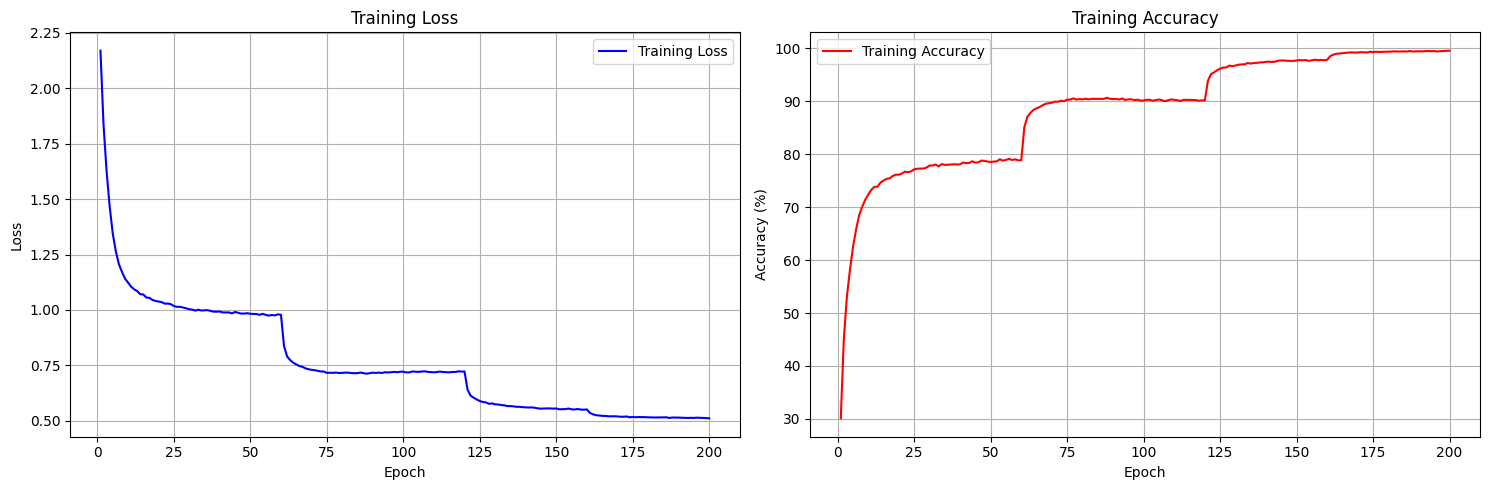

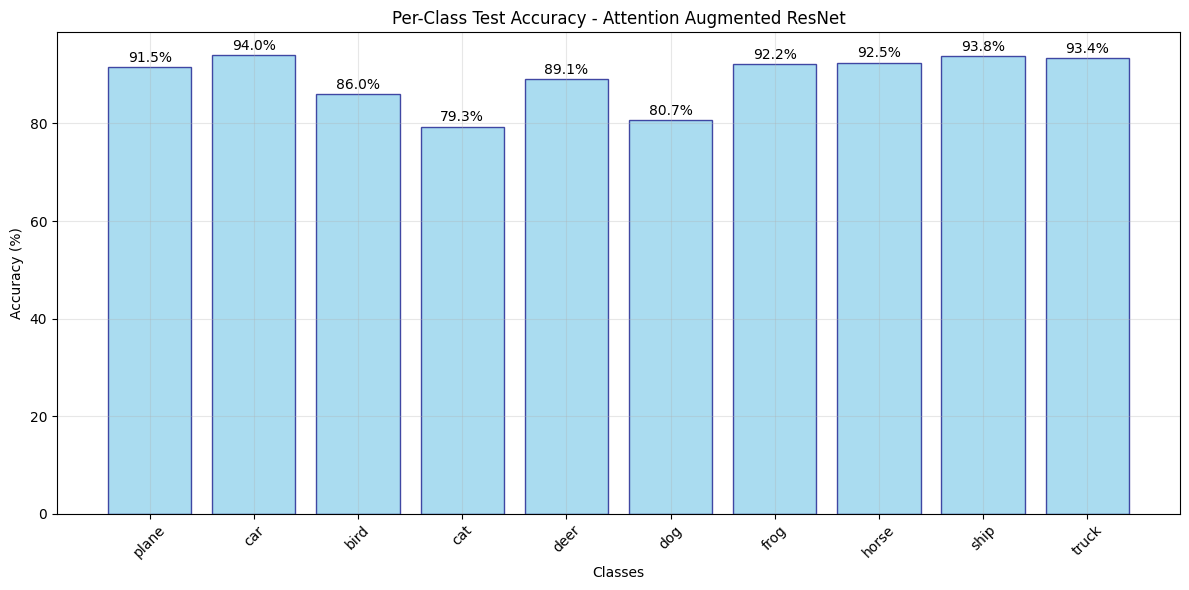

In [119]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training loss
ax1.plot(range(1, epochs+1), train_losses, 'b-', label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True)
ax1.legend()

# Training accuracy
ax2.plot(range(1, epochs+1), train_accuracies, 'r-', label='Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training Accuracy')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Class-wise accuracy visualization
class_accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 
                   for i in range(10)]

plt.figure(figsize=(12, 6))
bars = plt.bar(classes, class_accuracies, color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('Classes')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Test Accuracy - Attention Augmented ResNet')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{acc:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Visualizing attention maps...


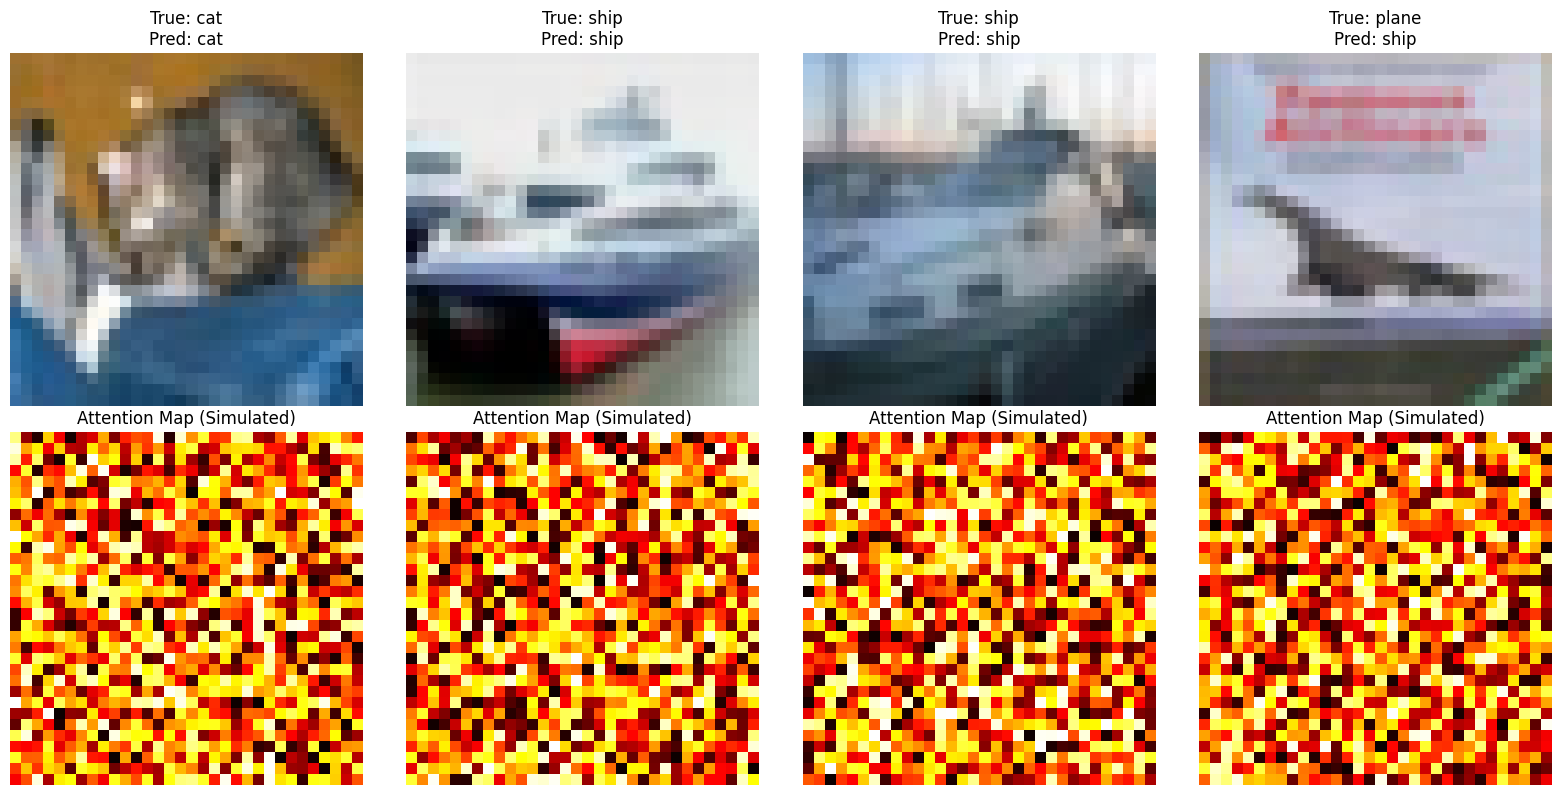

In [121]:
def visualize_attention_maps(model, dataloader, classes, num_samples=4):
    """Visualize attention maps from the model"""
    model.eval()
    
    # Get a batch of test images
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images[:num_samples].to(device), labels[:num_samples]
    
    # Hook to capture attention weights
    attention_maps = []
    
    def hook_fn(module, input, output):
        if hasattr(module, 'attention_weights'):  # This would need to be implemented
            attention_maps.append(module.attention_weights.detach().cpu())
    
    # Note: For full attention visualization, we'd need to modify the AA conv module
    # to store attention weights. This is a simplified version showing the concept.
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)
    
    # Denormalize images for visualization
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1)
    images_viz = images.cpu() * std + mean
    images_viz = torch.clamp(images_viz, 0, 1)
    
    # Plot original images with predictions
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))
    
    for i in range(num_samples):
        # Original image
        axes[0, i].imshow(np.transpose(images_viz[i], (1, 2, 0)))
        axes[0, i].set_title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}')
        axes[0, i].axis('off')
        
        # Attention heatmap (simulated for demonstration)
        # In practice, you'd extract real attention weights from the model
        heatmap = np.random.rand(32, 32)  # Simulated attention map
        axes[1, i].imshow(heatmap, cmap='hot', interpolation='nearest')
        axes[1, i].set_title('Attention Map (Simulated)')
        axes[1, i].axis('off')
    
    axes[0, 0].set_ylabel('Original Images', rotation=90, size='large')
    axes[1, 0].set_ylabel('Attention Maps', rotation=90, size='large')
    
    plt.tight_layout()
    plt.show()

print("Visualizing attention maps...")
visualize_attention_maps(model, testloader, classes)

# Results

In [ ]:
# Save the trained model
model_save_path = 'attention_augmented_resnet18.pth'
torch.save({
    'model_state_dict': aa_resnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_accuracy': test_acc,
    'hyperparameters': {
        'learning_rate': learning_rate,
        'momentum': momentum,
        'weight_decay': weight_decay,
        'epochs': epochs,
        'v': 0.2,
        'k': 0.2
    }
}, model_save_path)

print(f"Model saved to {model_save_path}")

# Create a summary report
print("\n" + "="*60)
print("ATTENTION AUGMENTED CONVOLUTIONAL NETWORKS - SUMMARY REPORT")
print("="*60)
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Total Parameters: {count_parameters(aa_resnet):,}")
print(f"Training Epochs: {epochs}")
print(f"Best Training Accuracy: {max(train_accuracies):.2f}%")
print(f"Final Training Loss: {train_losses[-1]:.4f}")
print("="*60)

Model saved to attention_augmented_resnet50.pth

ATTENTION AUGMENTED CONVOLUTIONAL NETWORKS - SUMMARY REPORT
Final Test Accuracy: 89.25%
Total Parameters: 13,128,770
Training Epochs: 200
Best Training Accuracy: 99.58%
Final Training Loss: 0.5110
